In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Activation
from keras.utils import np_utils
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from tensorflow.python.ops.numpy_ops.np_math_ops import log
import matplotlib.pyplot as plt
import numpy as np
from functools import wraps
from time import time
print(tf.__version__)


2.8.0


In [ ]:
def get_data():
  """
  Code copied from the link given in assignment description

  Returns
  -------
  tr_x : 60000,784 numpy array
  tr_y : 60000,10 numpy array
  te_x : 10000,784 numpy array
  te_y : 10000,10 numpy array
  
  """

  fashion_mnist = tf.keras.datasets.fashion_mnist

  # load the training and test data    
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()

  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)

  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0

  print( "Shape of training features ", tr_x.shape)
  print( "Shape of test features ", te_x.shape)

  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  # tr_y = tr_y.T
  print ("Shape of training labels ", tr_y.shape)

  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  # te_y = te_y.T
  print ("Shape of testing labels ", te_y.shape)

  return tr_x, tr_y, te_x, te_y

The figure below is from the lecture notes, it is an example if one instance X with n features mutiplied with n weights, all these products are added and passed through an activation layer (layed 1 - ReLu and layer 2 SoftMax to generate output y_predicted)

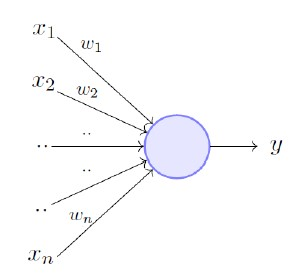

In [ ]:
def forward_pass(X, W1, B1, W2, B2, W3, B3, dropoutProb):
  """ 
  Performs forward pass for the neural network
  
  Parameters
  ----------
  X : 60000,784 TensorFlow Variables of training data
  W1 : 300,784 TensorFlow Variables of layer 1 weights 
  B1 : 300,1 TensorFlow Variables of layer 1 bias
  W2 : 100,300 TensorFlow Variables of layer 2 weights 
  B2 : 100,1 TensorFlow Variables of layer 2 bias
  W3 : 10,100 TensorFlow Variables of layer 3 weights 
  B3 : 10,1 TensorFlow Variables of layer 3 bias
  dropoutProb : int64, droupout probability in order to drop % of neurons from the layer

  Returns
  -------
  A3 : 60000,10 tensorflow variables of softmax layer output, probabilities of 10 classes of 60000 images
  """

  keepProb = 1 - dropoutProb  #1 - 0.2 = 0.8 (80% neurons ae kept) 

  #Layer1, ReLu activation with 300 neurons
  Z1 = tf.matmul(X,tf.transpose(W1)) + B1
  A1 = Activation('relu')(Z1) #shape 60,000 X 200

  #Dropping 20% of the neurons
  dropMatrix = tf.random.uniform([A1.shape[0], A1.shape[1]], minval=0, maxval=1) < keepProb
  A1 = A1 * dropMatrix #20% neurons are set to 0, or dropped for the next layer
  A1 = A1 / keepProb #to scale the 80% neuron to 100%

  #Layer2, ReLu activation with 100 neurons
  Z2 = tf.matmul(A1, tf.transpose(W2)) + B2 
  A2 = Activation('relu')(Z2)

  #Layer3, SoftMax layer with 10 neurons (10 classes)
  Z3 = tf.matmul(A2, tf.transpose(W3)) + B3
  A3 = tf.exp(Z3)/tf.reduce_sum(tf.exp(Z3), axis=-1).reshape(Z3.shape[0],1)
  # print(tf.reduce_sum(A2, axis=-1)) # checking if the probabilities add to 1 on all rows
  
  return A3


Muticlass Cross Entropy loss L is given by

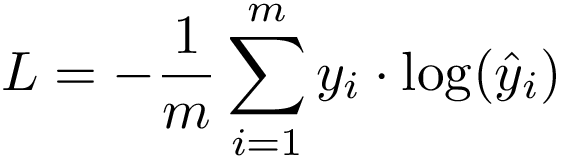


Where, 
yi is the ith instance true class lables,

y_cap_i is the ith predicted class probabilities,

m is the number of images in the dataset


In [ ]:
def cross_entropy(pred_y, true_y):
  """
  Performs Categorical Cross Entropy Loss calculation

  Parameters
  ----------
  pred_y : 60000,10 tensorflow variables from softmax layer - forward_pass()
  true_y : 60000,10 tensorflow variables of input image categorical lables 

  Returns
  -------
  loss : float32 value of Categorical Cross Entropy loss calculated as shown in the figure above
  """
  # cce = tf.keras.losses.CategoricalCrossentropy()
  # print("This is the loss from built in function", cce(true_y, pred_y).numpy())
  loss  = -tf.reduce_mean(tf.reduce_sum(true_y * (tf.math.log(pred_y)), axis=-1))
  return loss


In [ ]:
def calculate_accuracy(pred_y, true_y):
  """
  Calculate accuracy

  Parameters
  ----------
  pred_y : 60000,10 tensorflow variables from softmax layer - forward_pass()
  true_y : 60000,10 tensorflow variables of input image categorical lables 

  Returns
  -------
  acr : float32 value of Accuracy between predicted class and True class
  
    """
  pred_y = tf.round(pred_y)
  pred_correct = tf.cast(tf.equal(pred_y, true_y), tf.float32)
  acr = tf.reduce_mean(pred_correct)
  return acr

In [ ]:
def plotthis(drpout, epoc, plotdata, x_lable, location):
  for i in range(len(drpout)):
    x = range(epoc)
    name = "dropout p = "+ str(drpout[i])
    plt.plot(x, plotdata[i] ,label = name)
  plt.ylabel(x_lable)
  plt.xlabel("Epoch #")
  plt.legend(loc=location)
  plt.show()

In [ ]:
#Copied from Quora answers - https://stackoverflow.com/questions/2245161/how-to-measure-execution-time-of-functions-automatically-in-python
def timed(f):
    wraps(f)
    def wrapper(*args, **kwargs):
        start_time = time()
        res = f(*args, **kwargs)
        elapsed = time() - start_time
        print ("Execution time for function {} is: {} minutes".format(f.__name__, elapsed/60))
        return res
    return wrapper


Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (60000, 10)
Shape of testing labels  (10000, 10)
Iteration: 0, Loss: 2.5621931552886963, Accuracy: 0.8994166851043701
Iteration: 1, Loss: 2.1288676261901855, Accuracy: 0.8999983072280884
Iteration: 2, Loss: 1.8761780261993408, Accuracy: 0.9004416465759277
Iteration: 3, Loss: 1.6567809581756592, Accuracy: 0.9029383063316345
Iteration: 4, Loss: 1.4530646800994873, Accuracy: 0.9100900292396545
Iteration: 5, Loss: 1.297420859336853, Accuracy: 0.9214766621589661
Iteration: 6, Loss: 1.1687101125717163, Accuracy: 0.9276966452598572
Iteration: 7, Loss: 1.065885066986084, Accuracy: 0.9320316910743713
Iteration: 8, Loss: 0.9790851473808289, Accuracy: 0.9364916682243347
Iteration: 9, Loss: 0.9168391823768616, Accuracy: 0.9402999877929688
Iteration: 10, Loss: 0.8658229112625122, Accuracy: 0.9426733255386353
Iteration: 11, Loss: 0.8225322961807251, Accuracy: 0.9450666904449463
Iteration: 12, Loss

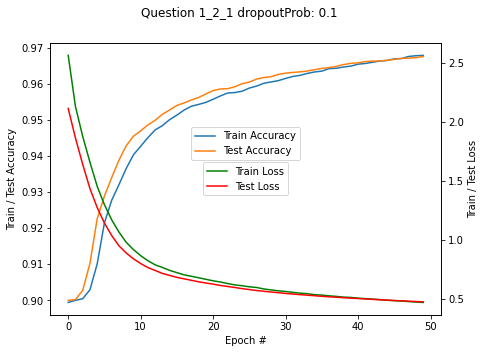

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (60000, 10)
Shape of testing labels  (10000, 10)
Iteration: 0, Loss: 2.582782030105591, Accuracy: 0.8940266370773315
Iteration: 1, Loss: 2.118162155151367, Accuracy: 0.8999999761581421
Iteration: 2, Loss: 1.9076130390167236, Accuracy: 0.9001466631889343
Iteration: 3, Loss: 1.7243976593017578, Accuracy: 0.9012249708175659
Iteration: 4, Loss: 1.5603389739990234, Accuracy: 0.9055266380310059
Iteration: 5, Loss: 1.4063494205474854, Accuracy: 0.9126816391944885
Iteration: 6, Loss: 1.268831491470337, Accuracy: 0.9203716516494751
Iteration: 7, Loss: 1.155971884727478, Accuracy: 0.9275649785995483
Iteration: 8, Loss: 1.0654606819152832, Accuracy: 0.9330383539199829
Iteration: 9, Loss: 0.9912854433059692, Accuracy: 0.9365933537483215
Iteration: 10, Loss: 0.9334803223609924, Accuracy: 0.9381683468818665
Iteration: 11, Loss: 0.8894710540771484, Accuracy: 0.9395549893379211
Iteration: 12, Loss: 

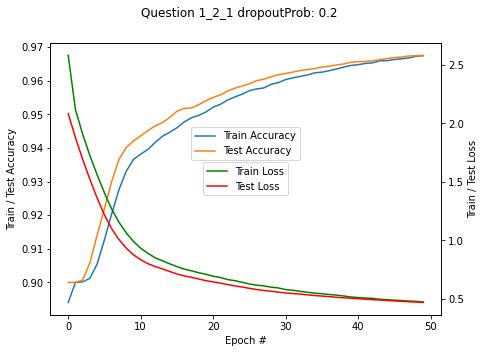

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (60000, 10)
Shape of testing labels  (10000, 10)
Iteration: 0, Loss: 2.475346803665161, Accuracy: 0.897255003452301
Iteration: 1, Loss: 2.094425916671753, Accuracy: 0.9000033140182495
Iteration: 2, Loss: 1.8714900016784668, Accuracy: 0.9002100229263306
Iteration: 3, Loss: 1.6667321920394897, Accuracy: 0.902263343334198
Iteration: 4, Loss: 1.4824414253234863, Accuracy: 0.9077933430671692
Iteration: 5, Loss: 1.3353605270385742, Accuracy: 0.9157216548919678
Iteration: 6, Loss: 1.2114068269729614, Accuracy: 0.9233816862106323
Iteration: 7, Loss: 1.1221404075622559, Accuracy: 0.928861677646637
Iteration: 8, Loss: 1.0492116212844849, Accuracy: 0.9332183599472046
Iteration: 9, Loss: 0.9892855286598206, Accuracy: 0.9359133243560791
Iteration: 10, Loss: 0.9465010166168213, Accuracy: 0.9375566840171814
Iteration: 11, Loss: 0.9053930044174194, Accuracy: 0.9389449954032898
Iteration: 12, Loss: 0

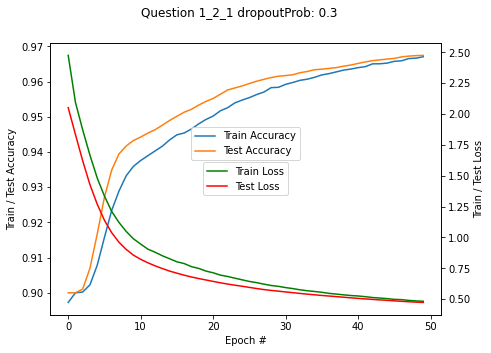

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (60000, 10)
Shape of testing labels  (10000, 10)
Iteration: 0, Loss: 2.5862181186676025, Accuracy: 0.8988983631134033
Iteration: 1, Loss: 2.177905559539795, Accuracy: 0.8999199867248535
Iteration: 2, Loss: 1.9368371963500977, Accuracy: 0.9002683162689209
Iteration: 3, Loss: 1.7448663711547852, Accuracy: 0.902543306350708
Iteration: 4, Loss: 1.5826120376586914, Accuracy: 0.9063199758529663
Iteration: 5, Loss: 1.4340122938156128, Accuracy: 0.9110783338546753
Iteration: 6, Loss: 1.309430480003357, Accuracy: 0.916338324546814
Iteration: 7, Loss: 1.2042385339736938, Accuracy: 0.9224500060081482
Iteration: 8, Loss: 1.1191445589065552, Accuracy: 0.9277899861335754
Iteration: 9, Loss: 1.0500121116638184, Accuracy: 0.9311950206756592
Iteration: 10, Loss: 0.9970987439155579, Accuracy: 0.9341483116149902
Iteration: 11, Loss: 0.9529076218605042, Accuracy: 0.9360116720199585
Iteration: 12, Loss: 

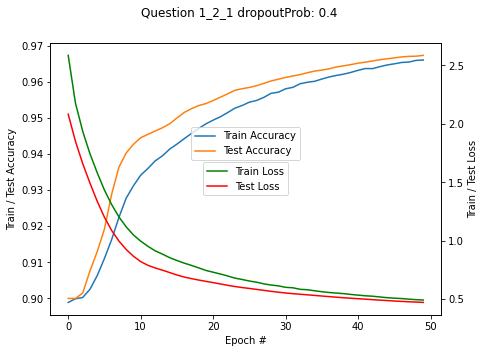

Shape of training features  (60000, 784)
Shape of test features  (10000, 784)
Shape of training labels  (60000, 10)
Shape of testing labels  (10000, 10)
Iteration: 0, Loss: 2.5241165161132812, Accuracy: 0.8982700109481812
Iteration: 1, Loss: 2.1149628162384033, Accuracy: 0.8998133540153503
Iteration: 2, Loss: 1.866103172302246, Accuracy: 0.9009950160980225
Iteration: 3, Loss: 1.6578528881072998, Accuracy: 0.9056083559989929
Iteration: 4, Loss: 1.488911747932434, Accuracy: 0.9125249981880188
Iteration: 5, Loss: 1.3516643047332764, Accuracy: 0.9181950092315674
Iteration: 6, Loss: 1.2440351247787476, Accuracy: 0.9228883385658264
Iteration: 7, Loss: 1.1490370035171509, Accuracy: 0.9274283051490784
Iteration: 8, Loss: 1.0799003839492798, Accuracy: 0.9307649731636047
Iteration: 9, Loss: 1.0216926336288452, Accuracy: 0.9328399896621704
Iteration: 10, Loss: 0.9778766632080078, Accuracy: 0.934291660785675
Iteration: 11, Loss: 0.9415421485900879, Accuracy: 0.9359533190727234
Iteration: 12, Loss:

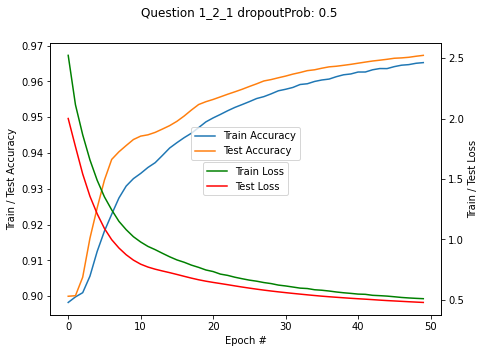

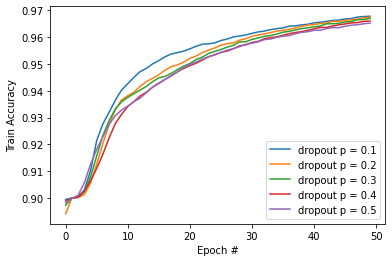

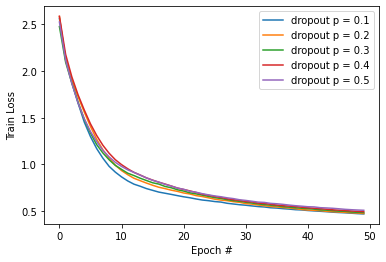

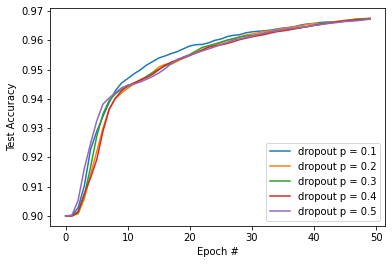

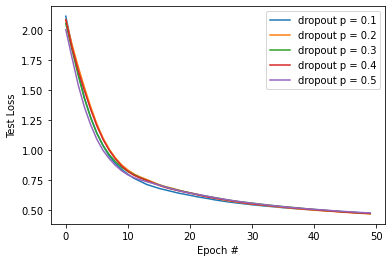

Execution time for function main is: 0.54664280017217 minutes


In [ ]:
@timed
def main():
  # tf.random.set_seed(50)
  num_Iters = 50
  dropOut = [0.1,0.2,0.3,0.4,0.5]
  # dropOut = [0.3]

  do_train_acc, do_train_loss, do_test_acc, do_test_loss = [], [], [], []
  
  for dropOutProb in dropOut:
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    train_loss, train_acc, test_loss, test_acc, epoc = [], [], [], [], []
    
    #get processed data from get_data()
    train_x, train_y, test_x, test_y = get_data()
    
    # Create tensorflow variables and change datatype to float64
    dt = tf.float32
    train_x = tf.cast(train_x, dt)
    train_y = tf.cast(train_y, dt)
    test_x = tf.cast(test_x, dt)
    test_y = tf.cast(test_y, dt)

    #when using RELU, multiply the weights with sqrt(2/n) to mitigate vanishing/exploding weights for large 'n' - Andrew Ng 
    W1 = tf.Variable(tf.random.normal([300,784]) * tf.sqrt(2/784))
    W2 = tf.Variable(tf.random.normal([100,300]) * tf.sqrt(2/300))
    W3 = tf.Variable(tf.random.normal([10,100]) * tf.sqrt(2/100))
    B1 = tf.Variable(tf.zeros([1]))
    B2 = tf.Variable(tf.zeros([1]))
    B3 = tf.Variable(tf.zeros([1]))

    for i in range(num_Iters):
      epoc.append(i)
      with tf.GradientTape() as tape:
        predicted_y = forward_pass(train_x, W1, B1, W2, B2, W3, B3, dropOutProb)
        crossEntLoss = cross_entropy(predicted_y, train_y) 
        train_loss.append(crossEntLoss)
      gradients = tape.gradient(crossEntLoss,[W1, W2, W3, B1, B2, B3])
      accuracy = calculate_accuracy(predicted_y, train_y)
      train_acc.append(accuracy)
      print("Iteration: {}, Loss: {}, Accuracy: {}".format(i, crossEntLoss, accuracy))

      adam_optimizer.apply_gradients(zip(gradients,[W1, W2, W3, B1, B2, B3]))

      #test data - validate
      pred_y = forward_pass(test_x, W1, B1, W2, B2, W3, B3, 0.0)
      loss = cross_entropy(pred_y, test_y)
      test_loss.append(loss)
      accuracy = calculate_accuracy(pred_y, test_y)
      test_acc.append(accuracy)

  # plotting four curves - https://stackoverflow.com/questions/67248885/plot-four-curve-with-one-x-axis-and-2-different-y-axis-on-the-same-plot-in-pytho
    fig = plt.figure(figsize=(7,5))
    fig.suptitle("Question 1_2_1 dropoutProb: "+str(dropOutProb))
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(epoc,train_acc, label = 'Train Accuracy')
    ax1.plot(epoc,test_acc, label = 'Test Accuracy')
    ax2.plot(epoc,train_loss, color='green', label = 'Train Loss')
    ax2.plot(epoc,test_loss, color='red', label = 'Test Loss')
    ax1.set_ylabel("Train / Test Accuracy")
    ax2.set_ylabel("Train / Test Loss")
    ax1.set_xlabel("Epoch #")
    ax1.legend(loc ='center', bbox_to_anchor=(0.5, 0.63))
    ax2.legend(loc= 'center', bbox_to_anchor=(0.5, 0.5))
    plt.show()

    do_train_acc.append(train_acc)
    do_train_loss.append(train_loss)
    do_test_acc.append(test_acc)
    do_test_loss.append(test_loss)

  plotthis(dropOut, num_Iters, do_train_acc, "Train Accuracy", 'lower right')
  plotthis(dropOut, num_Iters, do_train_loss, "Train Loss", 'upper right')
  plotthis(dropOut, num_Iters, do_test_acc, "Test Accuracy", 'lower right')
  plotthis(dropOut, num_Iters, do_test_loss, "Test Loss", 'upper right')

if __name__ == "__main__":
    main()